In [1]:
#Importando Paquetes


import pandas as pd
import seaborn as sns
from IPython.display import display
import numpy as np
import math



from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]




In [2]:
#Leyendo datos
df= pd.read_csv("C:/Users/LUISPEDRO/Desktop/Universidad Del Valle/Semestre 7/InteligenciaArtificial/Lab2/Walmart.csv")



## Exploración de datos

In [3]:
#Explorando un poco el dataframe... se ven 8 columnas con 6435 entradas
display(df.head())
print("Hay ", df.shape[0], " entradas")




,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


Hay  6435  entradas


In [4]:
#Será mas facil trabajar con los das, meses y anios por separado
#El dia de la semana se trabaja desde 0 a 6 (Lunes a domingo)

df.Date=pd.to_datetime(df.Date)

df['diaSemanal'] = df.Date.dt.weekday
df['mes'] = df.Date.dt.month
df['anio'] = df.Date.dt.year

df.drop(['Date'], axis=1, inplace=True)



In [6]:
#Isolando las columnas que no entran a nuestra predicción
prediccion = 'Weekly_Sales'
columnas = [i for i in df.columns if i not in [prediccion]]
original_df = df.copy(deep=True)

df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,diaSemanal,mes,anio
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,6,5,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,12,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,5,2010


In [32]:
#Numericas y Categoricas

nu = df[columnas].nunique().sort_values()
numerico= []
categorico = []
for i in range(df[columnas].shape[1]):
    if nu.values[i]<=45:
        categorico.append(nu.index[i])
    else: 
        numerico.append(nu.index[i])

print('Las variables numericas son', numerico)
print('Las variables categoricas son', categorico)


Las variables numericas son ['Unemployment', 'Fuel_Price', 'CPI', 'Temperature']
Las variables categoricas son ['Holiday_Flag', 'anio', 'diaSemanal', 'mes', 'Store']


In [33]:
#Breve análisis estadístico

display(df.describe())

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,diaSemanal,mes,anio
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,3.573427,6.475524,2010.965035
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,1.426581,3.321797,0.797019
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,0.000000,1.000000,2010.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,4.000000,4.000000,2010.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,4.000000,6.000000,2011.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,4.000000,9.000000,2012.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,6.000000,12.000000,2012.000000


## Preprocesamiento

In [44]:
#Buscando NA, NaN o NULL, ya que puede traer problemas

nulls = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Nulls Total'])
nulls['%'] = round(nulls['Nulls Total']/df.shape[0],3)*100
print(nulls)

              Nulls Total    %
Store                   0  0.0
Weekly_Sales            0  0.0
Holiday_Flag            0  0.0
Temperature             0  0.0
Fuel_Price              0  0.0
CPI                     0  0.0
Unemployment            0  0.0
diaSemanal              0  0.0
mes                     0  0.0
anio                    0  0.0


In [74]:
#Convertir Categorico a numerico

df2 = df.copy()
ecc = nulls[nulls['%']!=0].index.values
fcc = [i for i in categorico if i not in ecc]


oh=True
dm=True
for i in fcc:
    #print(i)
    if df2[i].nunique()==2:
        if oh==True: 
            print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i)
        oh=False
        df2[i]=pd.get_dummies(df2[i], drop_first=True, prefix=str(i))
    if (df2[i].nunique()>2):
        if dm==True: 
            print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i)
        dm=False
        df2 = pd.concat([df2.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df2[i], drop_first=True, prefix=str(i)))],axis=1)
        
df2.shape

One-Hot Encoding on features:
Holiday_Flag

Dummy Encoding on features:
anio
diaSemanal
mes
Store


(6435, 69)

In [11]:
#Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,anio_2011,anio_2012,diaSemanal_1,diaSemanal_2,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1643690.90,0,42.31,2.572,211.096358,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1641957.44,1,38.51,2.548,211.242170,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1611968.17,0,39.93,2.514,211.289143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1409727.59,0,46.63,2.561,211.319643,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1554806.68,0,46.50,2.625,211.350143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Inference:
Before removal of outliers, The dataset had 6435 samples.
After removal of outliers, The dataset now has 5953 samples.


In [12]:
df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

## Test y train

In [13]:
m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (5953, 68) (5953,) 
Training set  --->  (4762, 68) (4762,) 
Testing set   --->  (1191, 68)  (1191,)


In [14]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,anio_2011,anio_2012,diaSemanal_1,diaSemanal_2,diaSemanal_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,...,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03,4.762000e+03
mean,-1.741339e-16,-1.494674e-16,-3.367039e-16,-2.799804e-16,-4.039888e-16,3.964583e-16,3.839385e-16,-3.934507e-16,1.890317e-16,3.962484e-16,...,-4.515031e-16,-6.241216e-16,-1.086772e-15,-6.947287e-16,-2.611192e-17,3.944649e-16,-1.004738e-15,5.259687e-16,6.589880e-16,6.687683e-17
std,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,...,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00,1.000105e+00
min,-2.742012e-01,-2.961575e+00,-1.871814e+00,-1.248731e+00,-2.762670e+00,-7.526270e-01,-6.371530e-01,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
25%,-2.742012e-01,-7.314248e-01,-9.886990e-01,-1.076949e+00,-6.783836e-01,-7.526270e-01,-6.371530e-01,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
50%,-2.742012e-01,1.062547e-01,1.663112e-01,3.842133e-01,9.596435e-02,-7.526270e-01,-6.371530e-01,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
75%,-2.742012e-01,7.731979e-01,8.427860e-01,9.933828e-01,6.138095e-01,1.328679e+00,1.569482e+00,-2.588345e-01,-1.157891e-01,-2.719813e-01,...,-1.573123e-01,-1.587085e-01,-4.351484e-02,-1.580118e-01,-1.307162e-01,-1.537717e-01,-1.573123e-01,-1.628322e-01,-1.551967e-01,-1.523346e-01
max,3.646958e+00,2.170008e+00,2.469806e+00,1.340791e+00,2.575491e+00,1.328679e+00,1.569482e+00,3.863473e+00,8.636394e+00,3.676723e+00,...,6.356783e+00,6.300861e+00,2.298067e+01,6.328643e+00,7.650163e+00,6.503146e+00,6.356783e+00,6.141290e+00,6.443435e+00,6.564495e+00



                                          Standardardization on Testing set                                          


,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,anio_2011,anio_2012,diaSemanal_1,diaSemanal_2,diaSemanal_3,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,...,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,0.005646,0.044406,0.075113,0.021041,-0.050953,0.052984,0.065042,0.007679,0.038532,0.026409,...,-0.004168,-0.017693,0.111140,-0.010959,-0.000055,0.030677,-0.004168,-0.056970,0.016556,0.045053
std,1.009885,1.000220,0.971917,1.004644,1.010206,1.014188,1.028250,1.014142,1.152364,1.044095,...,0.987401,0.944330,1.881448,0.965939,1.000214,1.093088,0.987401,0.810380,1.051077,1.134875
min,-0.274201,-2.857425,-1.780457,-1.248731,-2.762670,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
25%,-0.274201,-0.657516,-0.852751,-1.077025,-0.699355,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
50%,-0.274201,0.187351,0.298996,0.393492,0.058860,-0.752627,-0.637153,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
75%,-0.274201,0.818764,0.844961,1.019967,0.611390,1.328679,1.569482,-0.258834,-0.115789,-0.271981,...,-0.157312,-0.158708,-0.043515,-0.158012,-0.130716,-0.153772,-0.157312,-0.162832,-0.155197,-0.152335
max,3.646958,2.035481,2.469806,1.345814,2.575491,1.328679,1.569482,3.863473,8.636394,3.676723,...,6.356783,6.300861,22.980668,6.328643,7.650163,6.503146,6.356783,6.141290,6.443435,6.564495


## Modelo Predictivo

In [15]:
#Let us first define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Intercept of the Regresion Model was found to be  1047603.298112138


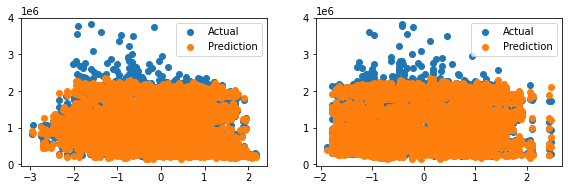



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9328296106281632
Residual Sum of Squares (RSS) on Training set  ---> 103518718391842.17
Mean Squared Error (MSE) on Training set       ---> 21738496092.36501
Root Mean Squared Error (RMSE) on Training set ---> 147439.8049794051

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9303017696577067
Residual Sum of Squares (RSS) on Training set  ---> 28393614754891.72
Mean Squared Error (MSE) on Training set       ---> 23840146729.548042
Root Mean Squared Error (RMSE) on Training set ---> 154402.54767829462

--------------------Residual Plots--------------------


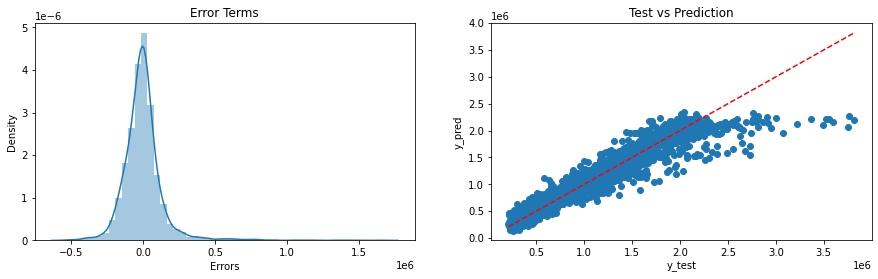

In [16]:
MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
#print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

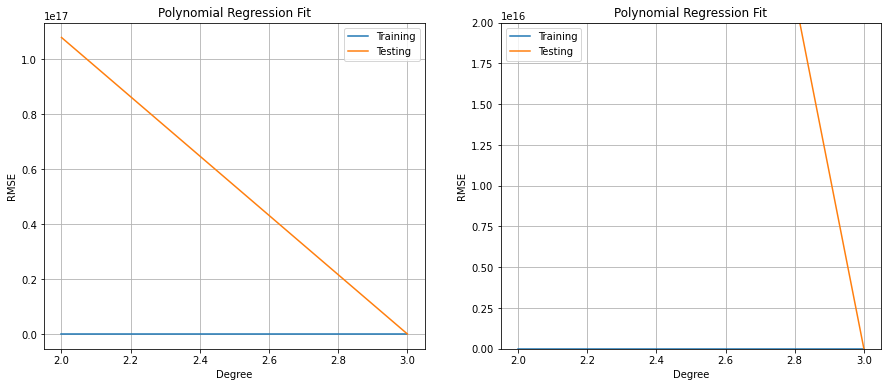

In [17]:
#Checking polynomial regression performance on various degrees

Trr=[]; Tss=[]
n_degree=4

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([0,2e16])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [   3435.79335565  -10914.64725803    4743.1403851   480582.61947727
  -60957.46755428  -30853.06569609  -70053.06421042    5298.18798047
  -11439.58286696  -13971.09128277  -16682.38674897  -12878.73710242
   -2292.83208474   28688.66514407   20184.61268466   20988.70814859
   22136.91951839   31592.44847738   19045.48814114   24450.25914354
   12307.58606646   16964.13937984   41316.13527305   62408.71207801
   55223.44198641 -184149.60630621  217287.32962979 -191432.43688823
   -9300.07974756 -105821.4808743  -120951.75707304 -163526.10852509
  217950.5039817   -40433.22685236   39645.7444887   223055.62594846
  131867.72296706    8382.11323863 -129777.84828956   51459.25405503
   87968.22878722  133612.12244755   93290.45823604 -121281.87572729
   67461.22478578   87415.76570356  124035.8303268  -125925.7954409

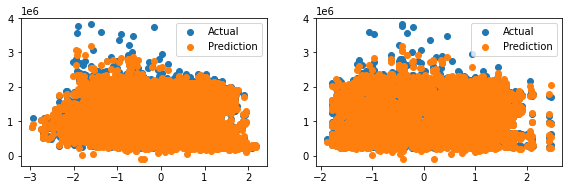



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9782529696974094
Residual Sum of Squares (RSS) on Training set  ---> 33515135565026.426
Mean Squared Error (MSE) on Training set       ---> 7038037707.901391
Root Mean Squared Error (RMSE) on Training set ---> 83893.01346298982

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> -3.402459578213252e+22
Residual Sum of Squares (RSS) on Training set  ---> 1.3860915264050257e+37
Mean Squared Error (MSE) on Training set       ---> 1.1638048080646733e+34
Root Mean Squared Error (RMSE) on Training set ---> 1.0787978531980277e+17

--------------------Residual Plots--------------------


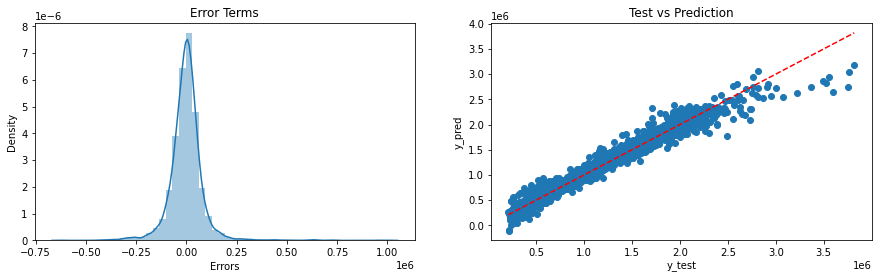

In [20]:
#Using the 2nd Order Polynomial Regression model (degree=2)

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)